## ECON 323 Final Project
### An Analysis of Airbnb Prices Across Popular Countries in Europe


Karina Grewal (section 004), Hrithik Soni (section 003)

## Introduction

### Reading data

In [174]:
#loading necessary packages
#!pip install opendatasets
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import glob, os
import seaborn as sns
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [175]:
#downloading datasets to a local folder
od.download("https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities")

Skipping, found downloaded files in "./airbnb-prices-in-european-cities" (use force=True to force download)


In [176]:
#accessing one dataset to take a peek at the data
amsterdam_weekdays = pd.read_csv('airbnb-prices-in-european-cities/amsterdam_weekdays.csv', index_col=0)
amsterdam_weekdays.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508


In [177]:
#trying to download all datasets
path = r'airbnb-prices-in-european-cities' 

# Get the files from the path provided in the OP
files = Path(path).glob('*.csv')  # .rglob to get subdirectories
dfs = list()

#appending all the different files into dataframes by filename of form city_time
for i, f in enumerate(files):
    data = pd.read_csv(f, index_col=0).assign(City=os.path.basename(f).split('.')[0])
    dfs.append(data)

#Combining into a single dataframe
df = pd.concat(dfs, ignore_index=True)

#splitting the file name into two columns with city name and weekday/weekend time period separate
df[['city', 'time']] = df.City.str.split("_", expand = True)
df = df.drop('City', axis=1)

#preview
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,time
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,weekdays


### EDA

#### Plot #1

In [178]:
#Creating coordinates for geopandas to read
df["Coordinates"] = list(zip(df.lng, df.lat))
df["Coordinates"] = df["Coordinates"].apply(Point)

gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,time,Coordinates
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,weekdays,POINT (4.90569 52.41772)
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,weekdays,POINT (4.90005 52.37432)
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,weekdays,POINT (4.97512 52.36103)
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,weekdays,POINT (4.89417 52.37663)
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,weekdays,POINT (4.90051 52.37508)


In [179]:
# Grab low resolution world file
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

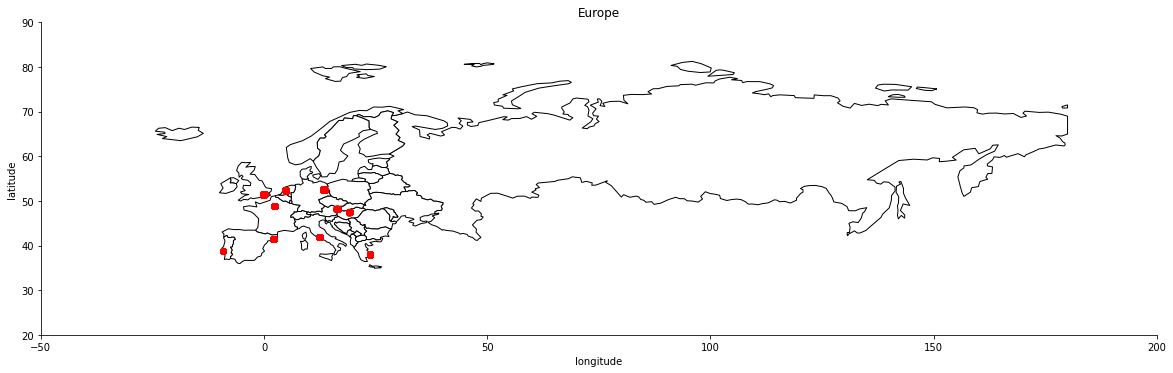

In [180]:
# Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(20,20))

# By only plotting rows in which the continent is 'Europe' we only plot, well,
# South America.
world.query("continent == 'Europe'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Europe')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.xlim(-50, 200)
plt.ylim(20, 90)

# Plotting the city names
# for x, y, label in zip(gdf['Coordinates'].x, gdf['Coordinates'].y, gdf['city']):
#     gax.annotate(label, xy=(x,y), xytext=(4,4), textcoords='offset points')
    
plt.show()

### Plot #2

(0.0, 11000.0)

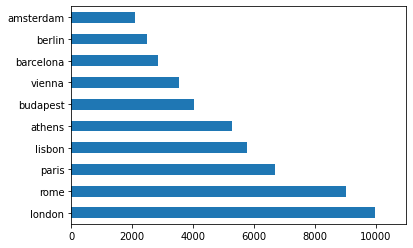

In [181]:
df["city"].value_counts().plot(kind = "barh")

plt.xlim(0, 11000)

### Plot #3: Price vs distance to city

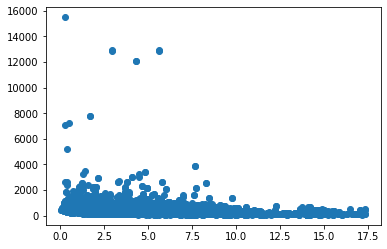

In [182]:
fig, ax = plt.subplots()

ams_rs = df.loc[df["city"] == "london"]["realSum"]
ams_cr = df.loc[df["city"] == "london"]["dist"]

ax.scatter(ams_cr, ams_rs)


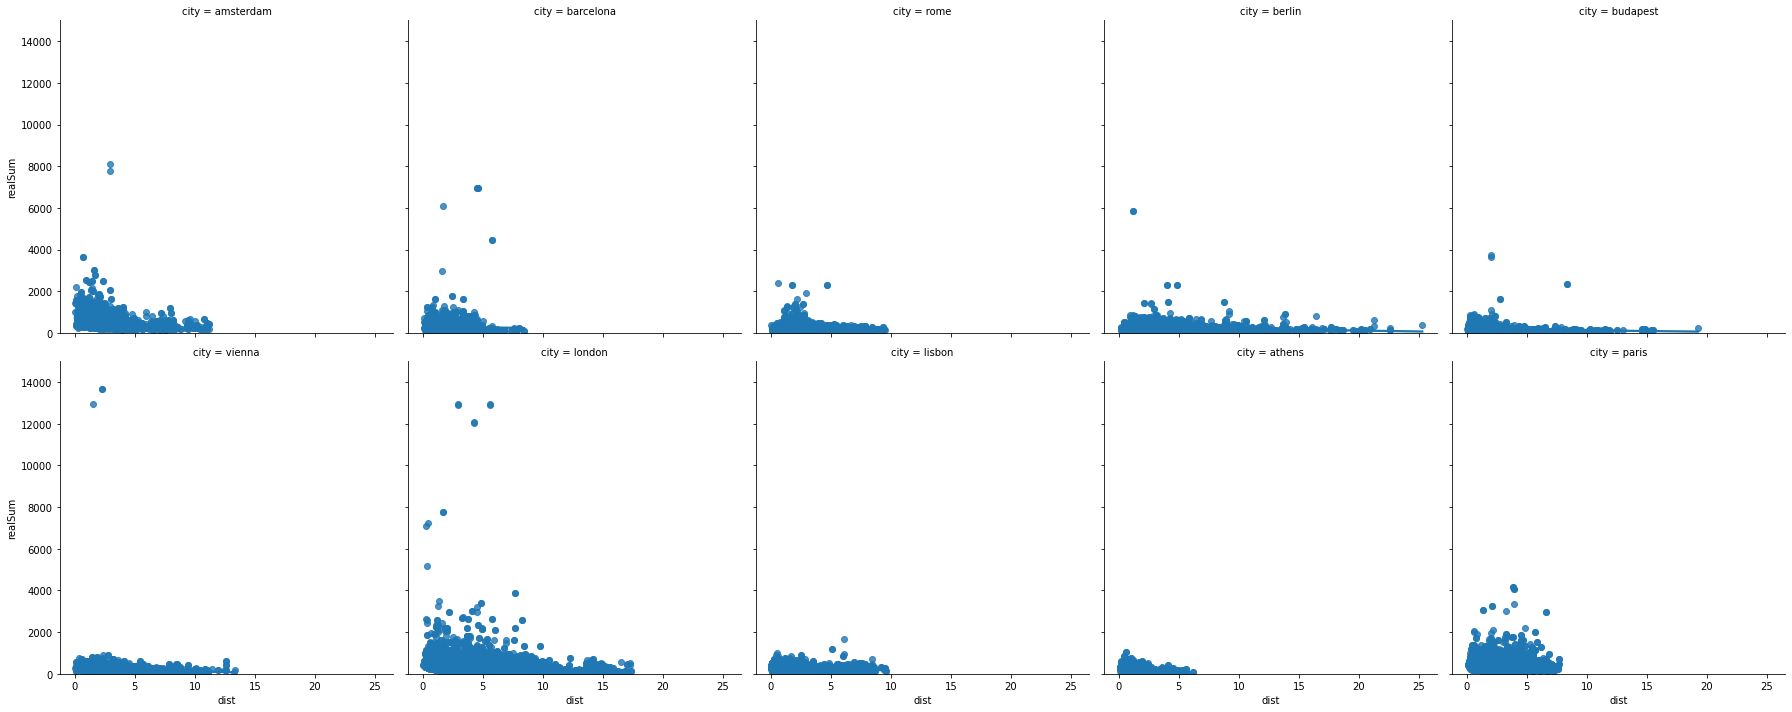

In [183]:
x = sns.lmplot(data=df, x='dist', y = 'realSum', col='city', col_wrap=5)
x.set(ylim = (0, 15000))

### Plot #4: Average price per city

<AxesSubplot: xlabel='city'>

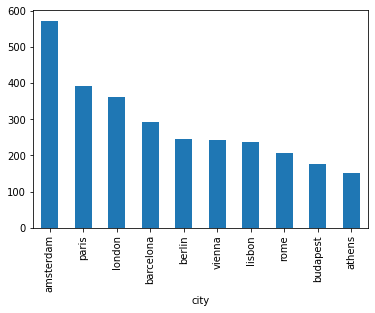

In [184]:
avg_price = df.groupby("city")["realSum"].mean()

avg_price.sort_values(ascending=False).plot.bar()

### Plot #5: Correlation heat map

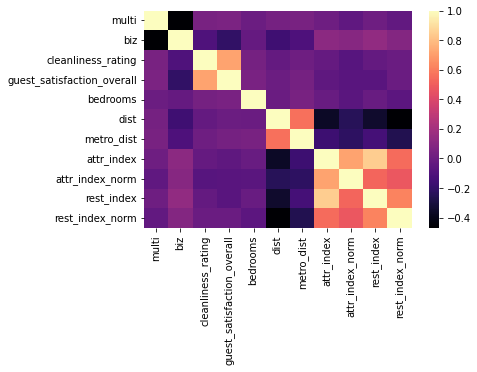

In [185]:
# Heatmap
df_heatmap = df.select_dtypes(include=np.number).iloc[:,2:-2]
df_heatmap

sns.heatmap(df_heatmap.corr(), annot = False, cmap = 'magma')
plt.show()

### Plot #6: Distribution Plot

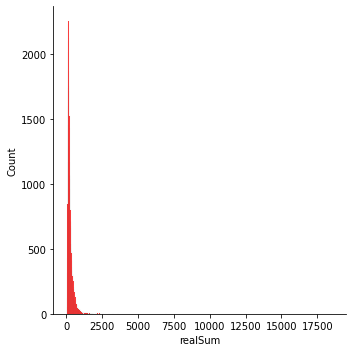

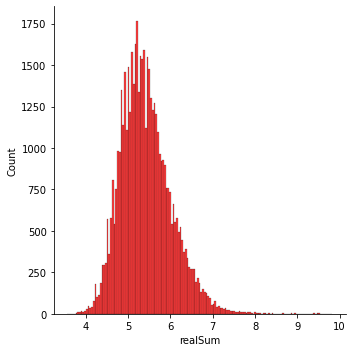

In [186]:
y = sns.displot(df['realSum'], color = 'r')

sns.displot(np.log(df['realSum']), color = 'r')

## Methods

### Prediction

#### 1. Full OLS

In [187]:
x = df.drop(["Coordinates", "realSum", "city", "attr_index", "rest_index"], axis=1)
X = pd.get_dummies(data=x, drop_first=True)
X["host_is_superhost"] = X["host_is_superhost"].astype(int)
X = X.drop(["room_shared", "room_private", "person_capacity"], axis = 1)
Y = np.log(df["realSum"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25)

airbnb_ols = linear_model.LinearRegression()
airbnb_ols.fit(X, Y)

# airbnb_ols = sm.OLS(y_train, x_train).fit()

# print(airbnb_ols.summary())

LinearRegression()

#### 2. Forward/Backward selection

##### Feature Selection using AIC, BIC, Mallow's $C_p$, and adjusted $R^2$

#### 3. Lasso Regression

##### Measuring MSE of the Prediction Models

In [188]:
#defining function to report mse values for models
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    report = dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )
    return print(f"{mod} reported mse: {report}")


fit_and_report_mses(linear_model.LinearRegression(), x_train, x_test, y_train, y_test)

LinearRegression() reported mse: {'mse_train': 0.15630989269907614, 'mse_test': 0.15364199000705095}


In [189]:
fit_and_report_mses(linear_model.Lasso(), x_train, x_test, y_train, y_test)

Lasso() reported mse: {'mse_train': 0.27002769446940794, 'mse_test': 0.2764904211917941}


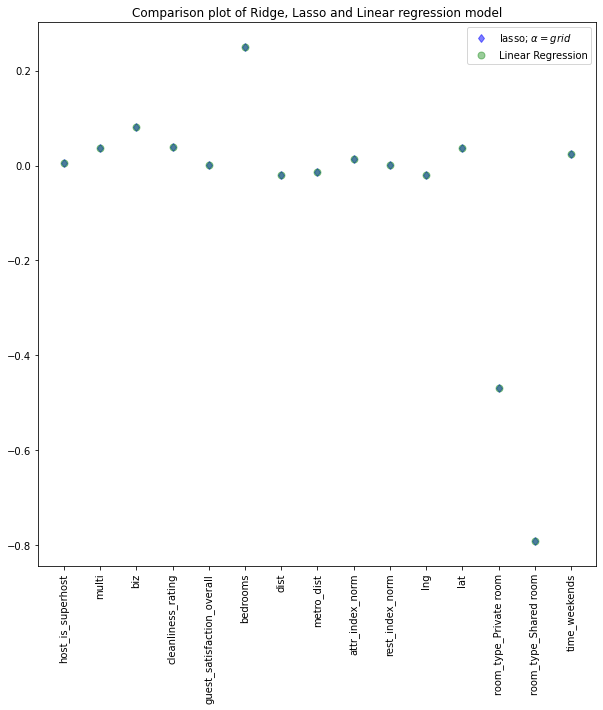

In [190]:
#plot size
# features = df.columns[0:11]
plt.figure(figsize = (10, 10))
#add plot for ridge regression
# plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(list(x_train), lasso_model.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

In [191]:
# LassoCV exploits special structure of lasso problem to minimize CV more efficiently
# lasso = linear_model.LassoCV(cv=5).fit(x_train,y_train)
# -np.log10(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

lasso_model = linear_model.Lasso()
lasso_model.fit(X, Y)

lasso_coefs = pd.Series(dict(zip(list(x_train), lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(list(X), airbnb_ols.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
host_is_superhost,-0.000000,0.005655
multi,-0.000000,0.037392
biz,0.000000,0.082135
cleanliness_rating,0.000000,0.038252
guest_satisfaction_overall,0.000000,0.000503
bedrooms,0.000000,0.249409
dist,-0.000000,-0.021011
metro_dist,-0.000000,-0.013975
attr_index_norm,0.014205,0.013588
rest_index_norm,0.002389,0.001627


#### 3. Lasso Regression

In [192]:
# Standardizing predictor variables

list_numerical = X.columns[3:12]

scaler = StandardScaler().fit(x_train[list_numerical]) 

x_train[list_numerical] = scaler.transform(x_train[list_numerical])

x_test[list_numerical] = scaler.transform(x_test[list_numerical])

x_train

,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,lng,lat,room_type_Private room,room_type_Shared room,time_weekends
20627,0,0,0,-0.410425,0.040859,1.348546,-0.780444,-0.191608,-0.373935,-1.042136,1.664396,-1.467920,0,0,1
37919,0,0,1,-0.410425,-0.631644,1.348546,-0.460055,-0.633379,0.067622,1.265277,-0.518271,0.609920,0,0,0
42543,0,0,0,0.638908,0.825447,1.348546,-0.173785,-0.606812,-0.621300,-0.384488,1.188089,0.352946,0,0,1
32516,0,0,1,0.638908,0.040859,-0.250837,-0.892483,-0.584536,-0.287502,0.023923,0.517713,-0.720673,1,0,1
45183,0,1,0,0.638908,0.265027,-0.250837,-0.978342,-0.027484,-0.585343,0.602515,-1.696026,-1.326334,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21029,0,0,1,-0.410425,-0.295392,-0.250837,-0.865253,-0.249189,0.311195,-0.984516,1.664908,-1.468547,0,0,1
32337,0,0,1,-1.459758,-1.416232,-0.250837,0.142541,-0.460125,-0.647462,-0.134534,0.515293,-0.724162,1,0,1
40354,0,0,0,-3.558423,-1.416232,2.947928,0.575968,1.094238,-0.960272,-1.167170,0.909493,0.489940,0,0,1
4748,0,1,0,-1.459758,-8.141270,-0.250837,-0.244179,0.731195,0.774391,2.022290,0.514256,-0.719289,0,0,0


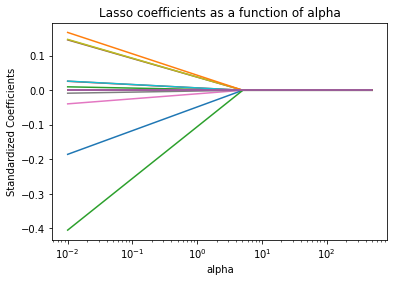

In [193]:
alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [194]:
# Lasso with 5 fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = LassoCV(alphas=arange(0.01, 10, 0.01), cv=cv, random_state=0)

# Fit model
model.fit(x_train, y_train)

print(model.alpha_)

lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(x_train, y_train)

mean_squared_error(y_test, lasso_best.predict(x_test))

0.01


0.16069375655106516

(0.007079812002696427,
 14.110544172917587,
 0.13667121076873182,
 0.39214474426550094)

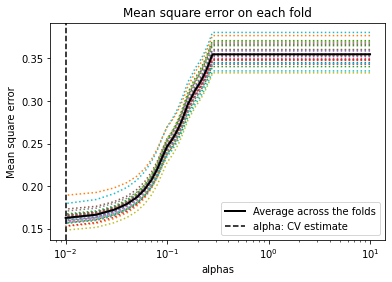

In [195]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

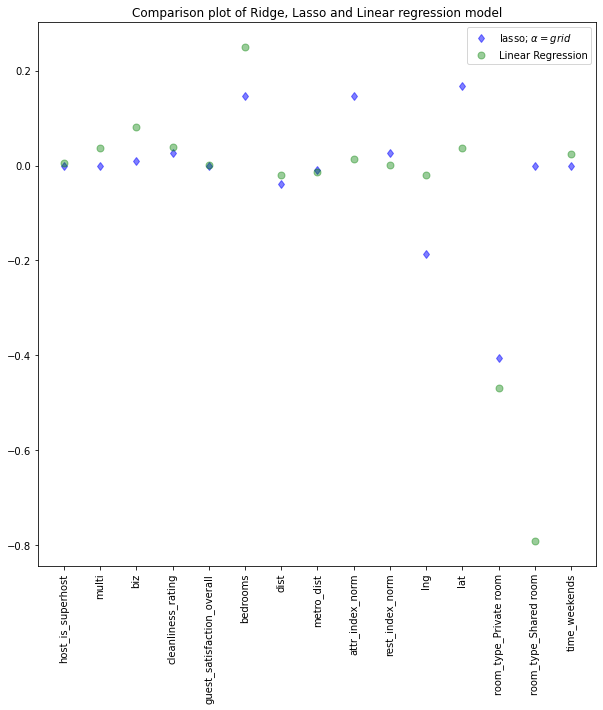

In [196]:
#plot size
# features = df.columns[0:11]
plt.figure(figsize = (10, 10))
#add plot for ridge regression
# plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(list(x_train), lasso_best.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

#### 4. Ridge Regression

In [197]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = RidgeCV(alphas = arange(0.1, 10, 0.1), cv=cv, scoring='neg_mean_absolute_error')

model.fit(x_train, y_train)

print(model.alpha_)

# Fit model
ridge_best = Ridge(alpha = model.alpha_)
ridge_best.fit(x_train, y_train)

ridge_best = Ridge(alpha=model.alpha_)
ridge_best.fit(x_train, y_train)

mean_squared_error(y_test, ridge_best.predict(x_test))

0.1


0.15364196279281284

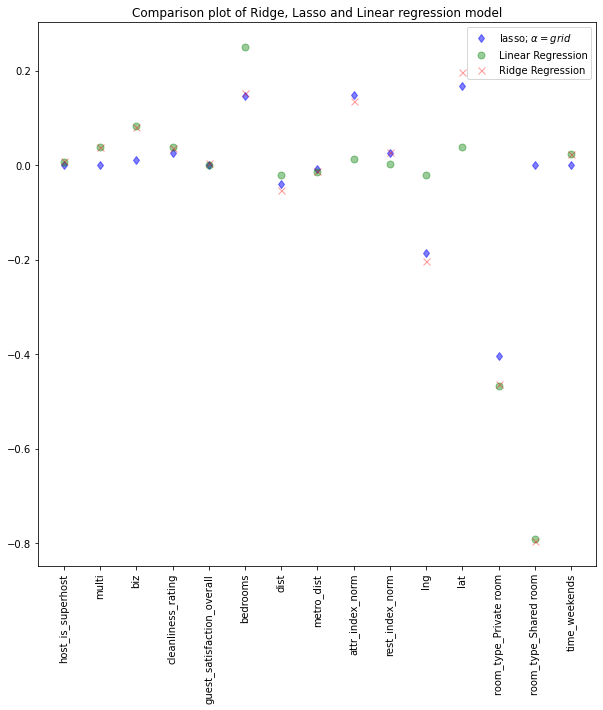

In [205]:
#plot size
# features = df.columns[0:11]
plt.figure(figsize = (10, 10))
#add plot for ridge regression
# plt.plot(features,ridgeReg.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(list(x_train), lasso_best.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(list(x_train), airbnb_ols.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#add plot for ridge model
plt.plot(list(x_train), ridge_best.coef_,alpha=0.4,linestyle='none',marker='x',markersize=7,color='red',label='Ridge Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

#### 5. Elastic Net

In [199]:
# # define model
# model = ElasticNet()
# # define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define grid
# grid = dict()
# grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
# grid['l1_ratio'] = arange(0, 1, 0.01)
# # define search
# search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # perform the search
# results = search.fit(x_train, y_train)
# # summarize
# print('MAE: %.3f' % results.best_score_)
# print('Config: %s' % results.best_params_)

KeyboardInterrupt: 

1. Forward/Backward selection
2. Ridge/Lasso/Elastic Net Regression
3. Classification: Random forests (Evaluate using ROC/AUC)

### Classification

#### 1. Random Forest